In [1]:
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
import scipy.stats as st
from scipy.optimize import fsolve
from scipy.special import gamma
import math

In [15]:
def distr(x, point):
    return np.sum(x <= point) / len(x)

def z_filter(data, columns, alpha = 2):
    result = data.copy()
    for column in columns:
        result = result[abs((result[column] - result[column].mean())/result[column].std()) < alpha]
    return result

def get_best_distribution(data):
    #dist_names = ["norm", "gamma", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "expon"]
    dist_names = ["weibull_max", "weibull_min"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    
    return best_dist, best_p, params[best_dist]

def f(alpha, beta, x):
    return 1 - np.exp(alpha * x ** beta) # 1 - e^(alpha*x^beta)

def weibull(k, scale, loc=0):
    def func(x):
        return k/scale * ((x-loc)/scale)**(k-1)*np.exp(-((x-loc)/scale)**k)
    return func

def minimum_square_method(func):
    def minimum_square_method_impl(coefs, x):
        alpha, beta = coefs
        x_new = np.arange(min(x), max(x), (max(x)-min(x)) / 100)
        y = list(map(lambda point: np.sum(x <= point) / len(x), x_new))
        return np.sum((func(alpha, beta)(x_new) - y)**2)
    return minimum_square_method_impl

def moment_method(sample_1, sample_2):
    beta = np.var(np.log(sample_1)) / (np.var(np.log(sample_2)))
    alpha = np.exp(-beta*np.mean(np.log(sample_2)) + np.mean(np.log(sample_1)))
    return alpha, beta

def calculate_Kolmogorov_statistic(sample_1, sample_2):
    y_sample_1 = list(map(lambda point: distr(sample_1, point), sample_1))
    y_sample_2 = list(map(lambda point: distr(sample_2, point), sample_2))
    n1 = sample_1.shape[0]
    n2 = sample_2.shape[0]
    data_all = np.concatenate([y_sample_1, y_sample_2])
    cdf1 = np.searchsorted(y_sample_1, data_all, side='right') / n1
    cdf2 = np.searchsorted(y_sample_2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.clip(-cddiffs[np.argmin(cddiffs)], 0, 1)
    max_diff = cddiffs[np.argmax(cddiffs)]
    result = minS if minS > max_diff else max_diff
    print(f"DNM: {result}")
    return result * np.sqrt(max(len(sample_1),len(sample_2)))


def estimate_weibull_params_moments(data):
    x_mean = data.mean()
    x_var = data.var(ddof=1)
    
    def moment_method_for_weibull(k):
        lam = x_mean / gamma(1 + 1.0/k)
        theor_var = lam**2 * (gamma(1 + 2.0/k) - gamma(1 + 1.0/k)**2)
        return x_var - theor_var  
    
    k_initial_guess = 1.0  
    k_solution, = fsolve(moment_method_for_weibull, x0=k_initial_guess)
    
    lam_solution = x_mean / gamma(1 + 1.0/k_solution)
    
    return k_solution, lam_solution

In [33]:
data = pd.read_csv('diabetes.csv', sep=',').drop_duplicates()
data = z_filter(data, ['SkinThickness', 'Glucose', 'BloodPressure', 'Pregnancies', 'BMI', 'Age'], alpha=3)
#mean_value = data.loc[:, 'SkinThickness'].mean()
#data['SkinThickness'].replace(0, mean_value)
print(data.shape[0])
data

712


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
first_type, second_type = data[data['Insulin'] == 0], data[data['Insulin'] > 0]
first_type = first_type.drop(columns=['Insulin', "Pregnancies", "BloodPressure", "SkinThickness","BMI", "DiabetesPedigreeFunction", "Age", "Outcome"])
second_type = second_type.drop(columns=['Insulin', "Pregnancies", "BloodPressure", "SkinThickness","BMI", "DiabetesPedigreeFunction", "Age", "Outcome"])
print(f"first type size: {first_type.axes[0].size}, second type size: {second_type.axes[0].size}")

first type size: 328, second type size: 384


In [5]:
#train_data, test_data = train_test_split(first_type, test_size=0.20, random_state=42)
first_type = first_type.sort_values('Glucose').reset_index(drop=True)
train_data, test_data = first_type.loc[::2].reset_index(drop=True), first_type.loc[1::2].reset_index(drop=True)
second_type = second_type.sort_values('Glucose').reset_index(drop=True)
train_data2, test_data2 = second_type.loc[::2].reset_index(drop=True), second_type.loc[1::2].reset_index(drop=True)
print(f"train_size: {train_data.shape[0]}, test_size: {test_data.shape[0]}")

train_size: 164, test_size: 164


Text(0.5, 1.0, 'Density')

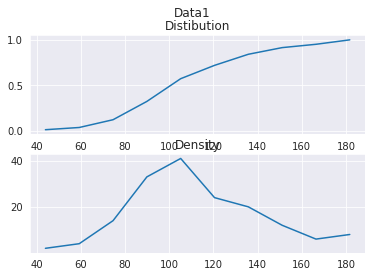

In [6]:
hist_1, bin_edges_1 = np.histogram(train_data['Glucose'])
values_1 = np.cumsum(hist_1/np.sum(hist_1))
fig_1, axs_1 = plt.subplots(2)
fig_1.suptitle('Data1')
axs_1[0].plot(bin_edges_1[:-1], values_1)
axs_1[0].set_title("Distibution")
axs_1[1].plot(bin_edges_1[:-1], hist_1)
axs_1[1].set_title("Density")

In [12]:
best_dist, p_val, params = get_best_distribution(train_data['Glucose'])

p value for weibull_max = 1.8573485435222076e-98
p value for weibull_min = 0.40903825957571904
Best fitting distribution: weibull_min
Best p value: 0.40903825957571904
Parameters for the best fit: (np.float64(2.3856347736343393), np.float64(53.34493461175144), np.float64(75.91012957478425))


array([0.        , 0.00046941, 0.00154229, 0.0028691 , 0.00403845,
       0.00464395, 0.00525659, 0.00556408, 0.0061784 , 0.00678797,
       0.00678797, 0.00738824, 0.00768349, 0.00797478, 0.00826156,
       0.00826156, 0.00826156, 0.00854333, 0.00881957, 0.00935353,
       0.00961031, 0.00961031, 0.00961031, 0.00985968, 0.00985968,
       0.00985968, 0.01010122, 0.01010122, 0.01010122, 0.0103345 ,
       0.01055915, 0.01077477, 0.01077477, 0.01077477, 0.01098102,
       0.01117755, 0.01117755, 0.01154027, 0.01154027, 0.01154027,
       0.0117059 , 0.0118607 , 0.0118607 , 0.01200447, 0.01200447,
       0.01200447, 0.012137  , 0.012137  , 0.01225812, 0.01225812,
       0.0123677 , 0.0123677 , 0.0123677 , 0.01246561, 0.01246561,
       0.01246561, 0.01246561, 0.01246561, 0.01255176, 0.01255176,
       0.01255176, 0.01262609, 0.01262609, 0.01262609, 0.01262609,
       0.01268855, 0.01268855, 0.01273913, 0.01273913, 0.01277785,
       0.01277785, 0.01277785, 0.01277785, 0.01277785, 0.01280

In [ ]:
k, lam = estimate_weibull_params_moments(train_data['Glucose'])
print(f"k: {k}, lam: {lam}")
dx = np.arange(np.min(test_data['Glucose']), np.max(test_data['Glucose']), (np.max(test_data['Glucose'])-np.min(test_data['Glucose'])) / 164)
wf = weibull(k, lam)
plt.plot(dx, [wf(val) for val in dx], color='red', label='Weibull-Raw')
plt.plot(dx, st.weibull_min.pdf(dx, params[0], loc=params[1], scale=params[2]), color='blue', label='Weibull-Lib')
sns.histplot(test_data['Glucose'], bins=30, stat='density', color='skyblue', alpha=0.6)

In [28]:
res_1 = scipy.optimize.minimize(minimum_square_method(weibull), [-0.1, 0.3], args = (train_data['Glucose'], ))
alpha_1, beta_1 = res_1.x
print(f'Оценка Альфа_1: {alpha_1}')
print(f'Оценка Бета_1: {beta_1}')

Оценка Альфа_1: 0.6712316513061524
Оценка Бета_1: 0.283518123626709


NameError: name 'alpha' is not defined

In [7]:
alpha, beta = moment_method(train_data['Glucose'], train_data2['Glucose'])
print(f"alpha_estimated:{alpha}, beta_estimated:{beta}")

alpha_estimated:0.7815849711835694, beta_estimated:1.0480068507277494


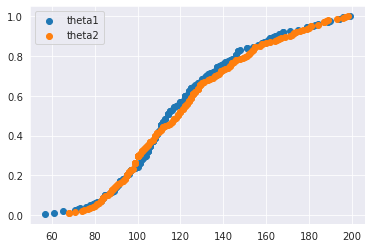

In [8]:
def distr(x, point):
    return np.sum(x <= point) / len(x)
plt.scatter(test_data['Glucose'], list(map(lambda point: distr(alpha*test_data['Glucose']**beta, point), alpha*test_data['Glucose']**beta)), label = 'theta1')
plt.scatter(test_data2['Glucose'], list(map(lambda point: distr(test_data2['Glucose'], point), test_data2['Glucose'])), label = 'theta2')
plt.legend()

In [10]:
kolmogorov_stat = calculate_Kolmogorov_statistic(test_data2['Glucose'], alpha * (test_data['Glucose']**beta))
alpha = 0.05   # 5%
K_alpha = np.sqrt(-1/2 * np.log((1 - alpha) / 2))
print(f"K_alpha: {K_alpha}")
print(f"Статистика Колмогорова: {kolmogorov_stat}")
if kolmogorov_stat < K_alpha:
    print("Гипотеза H0 принимается")
else:
    print("Гипотеза H0 отвергается")

DNM: 0.03226626016260159
K_alpha: 0.6100985473460397
Статистика Колмогорова: 0.4470944157748926
Гипотеза H0 принимается


In [41]:
from scipy.stats import ks_2samp, ks_1samp
stat, p_value =  ks_2samp(test_data2['Glucose'], alpha * (test_data['Glucose']**beta))
print("KS statistic:", stat)
print("p-value:", p_value)
ks_1samp

KS statistic: 0.3861774344569288
p-value: 3.872066338447972e-17


<function scipy.stats._stats_py.ks_1samp(x, cdf, args=(), alternative='two-sided', mode='auto')>

In [37]:
data = pd.read_csv('diabetes.csv', sep=',').drop_duplicates()
data = z_filter(data, ['SkinThickness', 'Glucose', 'BloodPressure', 'Pregnancies', 'BMI', 'Age'], alpha=3)
mean_value = data.loc[:, 'Insulin'].mean()
data['Insulin'].replace(0, mean_value, inplace=True)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,84.582865,33.6,0.627,50,1
1,1,85,66,29,84.582865,26.6,0.351,31,0
2,8,183,64,0,84.582865,23.3,0.672,32,1
3,1,89,66,23,94.000000,28.1,0.167,21,0
4,0,137,40,35,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.000000,32.9,0.171,63,0
764,2,122,70,27,84.582865,36.8,0.340,27,0
765,5,121,72,23,112.000000,26.2,0.245,30,0
766,1,126,60,0,84.582865,30.1,0.349,47,1


In [38]:
cleansed_data = data.drop(columns=["Pregnancies", "BloodPressure", "SkinThickness","BMI", "DiabetesPedigreeFunction", "Age", "Outcome"])
print(f"first type size: {cleansed_data.axes[0].size}")
cleansed_data = cleansed_data.sort_values('Glucose').reset_index(drop=True)
train_data, test_data = cleansed_data.loc[::2].reset_index(drop=True), cleansed_data.loc[1::2].reset_index(drop=True)
print(f"train_size: {train_data.shape[0]}, test_size: {test_data.shape[0]}")

first type size: 712
train_size: 356, test_size: 356


0.2706718288920167
alpha_estimated:39.5281909612684, beta_estimated:0.23615332676881431


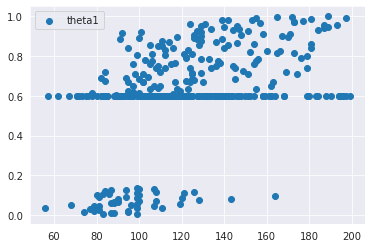

In [40]:
def distr(x, point):
    return np.sum(x <= point) / len(x)


alpha, beta = moment_method(train_data['Glucose'], train_data['Insulin'])
print(f"alpha_estimated:{alpha}, beta_estimated:{beta}")
plt.scatter(test_data['Glucose'], list(map(lambda point: distr(alpha*test_data['Insulin']**beta, point), alpha*test_data['Insulin']**beta)), label = 'theta1')
plt.legend()